# **Informaciones**

**Trabajo personal, semana 6**

*Santiago Lamas Fresard*

# **Inicialización**

In [1]:
using Distributions, Gurobi, Ipopt, JuMP, LinearAlgebra, Measures, Plots, Random, Roots, SDDP

const GRB_ENV = Gurobi.Env();

Set parameter Username
Set parameter LicenseID to value 2760931
Academic license - for non-commercial use only - expires 2027-01-05


# **Modelos**

*Single-species, multiaged forest model, taken from "A Discussion of Vintage Optimization Models in Forest Economics", A. Piazza, Forest Science, Vol 66(4) pp.469-477, 2020.*

## **Estimación de la función de costos**

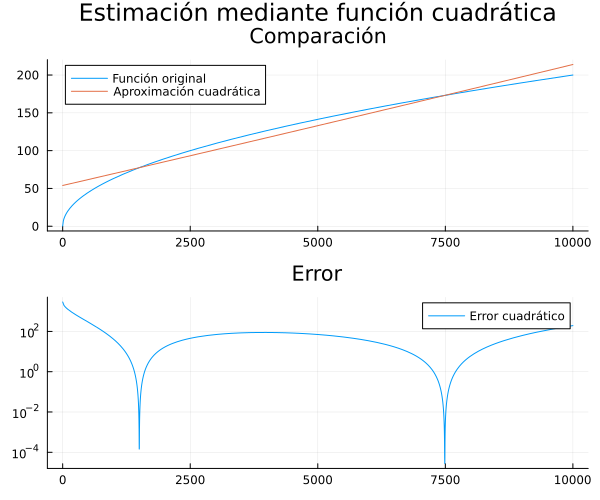

In [2]:
# Encuentra los parámetros que mejor aproximan la función x^(1-α)/(1-α) de acuerdo a la norma L^2([0,T])
function params_optimos(α, T)
    A = [T^5/5 T^4/4 T^3/3; T^4/4 T^3/3 T^2/2; T^3/3 T^2/2 T]
    b = [T^(4-α)/(4-α); T^(3-α)/(3-α); T^(2-α)/(2-α)]/(1-α)
    return A^-1*b
end

# Ejemplo: fijación de parámetros
α_ej, T_ej = 0.5, 10000
a_ej, b_ej, c_ej = params_optimos(α_ej, T_ej)

# Funciones a usar
quad_ej = x -> a_ej*x^2 + b_ej*x + c_ej
raiz_ej = x -> x^(1-α_ej)/((1-α_ej))
l2norm = x -> (quad_ej(x) - raiz_ej(x))^2

# Graficado
p1 = plot(raiz_ej, 0.01, T_ej, label="Función original")
plot!(quad_ej, 0.01, T_ej, label="Aproximación cuadrática", title="Comparación")
p2 = plot(l2norm, 0.01, T_ej, yaxis=:log10, label="Error cuadrático", title="Error")
plot(p1, p2, layout=(2,1), size=(600,500), plot_title="Estimación mediante función cuadrática")

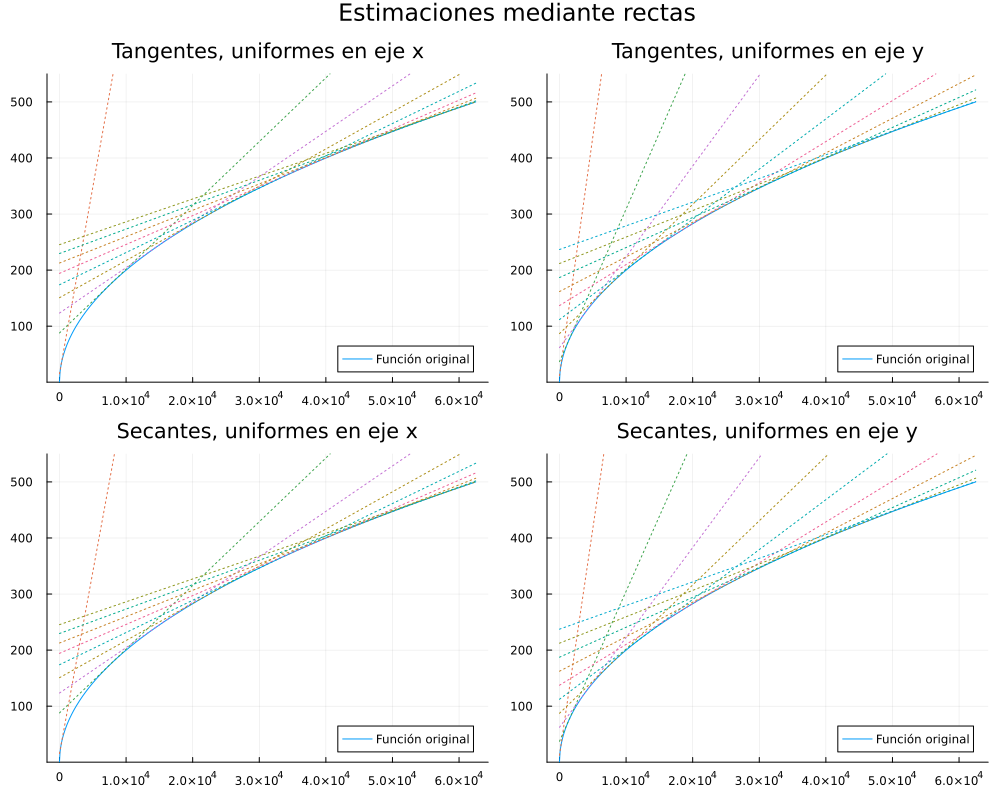

In [3]:
# Parámetros a usar en el problema
α = 0.5 # risk aversion parameter for the utility function
UB = 500 # upper bound for the objective function

# Funciones útiles
obj = x -> x^(1-α)/(1-α) # función objetivo
deriv_obj = x -> x^-α # derivada de función objetivo
inv_obj = y -> ((1-α)*y)^(1/(1-α)) # inversa de función objetivo

# Parámetros para estimar la función objetivo
T = inv_obj(UB)
nx, ny = 2500, 200 # número de puntos para discretizar 
dx, dy = T/nx, UB/ny # pasos para discretizar

# Aproximación por una función cuadrática
a, b, c = params_optimos(α, T)
approx_quad = x -> a*x^2 + b*x + c

# Discretización de los intervalos a trabajar
d_unif_x = 1:dx:T # uniforme en eje x
d_unif_y = 1:dy:UB          # uniforme en eje y

# Imagen y preimagen de las discretizaciones
f_unif_x = obj.(d_unif_x)    # uniforme en eje x
f_inv_y = inv_obj.(d_unif_y) # uniforme en eje y

# Aproximación mediante tangentes:
a_tgte_x = deriv_obj.(d_unif_x)             # pendiente uniforme en eje x
b_tgte_x = f_unif_x .- a_tgte_x .* d_unif_x # ordenada al origen uniforme en eje x
a_tgte_y = deriv_obj.(f_inv_y)              # pendiente uniforme en eje y
b_tgte_y = d_unif_y .- a_tgte_y .* f_inv_y  # ordenada al origen uniforme en eje y

# Aproximación mediante interpolación lineal:
a_sec_x = [(f_unif_x[i+1] - f_unif_x[i])/dx for i in 1:nx-1] # pendiente uniforme en eje x
b_sec_x = f_unif_x[1:nx-1] .- a_sec_x .* d_unif_x[1:nx-1] # ordenada al origen uniforme en eje x
a_sec_y = [dy/(f_inv_y[i+1] - f_inv_y[i]) for i in 1:ny-1]   # pendiente uniforme en eje y
b_sec_y = d_unif_y[1:ny-1] .- a_sec_y .* f_inv_y[1:ny-1]  # ordenada al origen uniforme en eje y

# Graficado
p1 = plot(obj, 0.1, T, ylims=(0.1,UB+50), label="Función original", title="Tangentes, uniformes en eje x")
for i in 10:300:nx
    plot!(x -> a_tgte_x[i]*x + b_tgte_x[i], label=false, linestyle=:dot)
end
p2 = plot(obj, 0.1, T, ylims=(0.1,UB+50), label="Función original", title="Tangentes, uniformes en eje y")
for i in 10:20:ny
    plot!(x -> a_tgte_y[i]*x + b_tgte_y[i], label=false, linestyle=:dot)
end
p3 = plot(obj, 0.1, T, ylims=(0.1,UB+50), label="Función original", title="Secantes, uniformes en eje x")
for i in 10:300:nx-1
    plot!(x -> a_sec_x[i]*x + b_sec_x[i], label=false, linestyle=:dot)
end
p4 = plot(obj, 0.1, T, ylims=(0.1,UB+50), label="Función original", title="Secantes, uniformes en eje y")
for i in 10:20:ny-1
    plot!(x -> a_sec_y[i]*x + b_sec_y[i], label=false, linestyle=:dot)
end
plot(p1, p2, p3, p4, layout=(2,2), size=(1000,800), plot_title="Estimaciones mediante rectas")

## **Prueba de modelos**

### **Fijación de parámetros**

In [18]:
UB = 5000 # upper bound for the objective function
b = 0.975 # discount factor used by Buongiorno
α = 0.5 # risk aversion parameter for the utility function
n = 5 # number of age classes
f = [0.8, 4.2, 16.99, 68.1, 84] # biomass coeffcients
x0 = [1.0, 0.0, 0.0, 0.0, 0.0] # initial state

# Creamos un gráfico cíclico de un nodo con probablidad (1-b) de salir del ciclo 
graph = SDDP.UnicyclicGraph(b; num_nodes = 1)

# Número de iteraciones para entrenar y simulaciones
n_train_iterations = 50
n_simulations = 100;

In [ ]:
function build_model(coefs_a, coefs_b)
    n_coefs = length(coefs_a)
    model = SDDP.PolicyGraph(
        graph;
        sense = :Max,
        upper_bound = UB,
        # optimizer = Ipopt.Optimizer,
        optimizer = () -> Gurobi.Optimizer(GRB_ENV),
    ) do sp, t
        # variable: madera 
        @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional.
        @variable(sp, c[1:n] >= 0) # control variables
        @variable(sp, TV >= 0) # Timber volume
        @variable(sp, u >= 0) # slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
        @constraints(sp, begin
            c[n] == x[n].in # we harvest everything for the oldest age class
            [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
            sum(f[s] * c[s] for s in 1:n) == TV # timber volume
            [s = 1:n], x[s].out <= 1 # state space constraints
            sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
            [s = 1:n_coefs], u <= coefs_a[s]*TV + coefs_b[s] #forces u to be approx. TV^(1-α)/(1-α)
        end)
        @stageobjective(sp, u)
    end
    SDDP.numerical_stability_report(model)
    SDDP.train(model, iteration_limit = n_train_iterations)
    # Simulations to compute bounds. These will have different lengths.
    simulations = SDDP.simulate(model, n_simulations, [:x])
    objective_values = [
        sum(stage[:stage_objective] for stage in sim) for sim in simulations
    ]
    μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
    upper_bound = SDDP.calculate_bound(model)
    println("Confidence interval: ", μ, " ± ", ci)
    println("Upper bound: ", round(upper_bound, digits = 2))
end;

### **Función cuadrática**

In [ ]:
model0 = SDDP.PolicyGraph(
    graph;
    # maximizamos función de retorno
    sense = :Max,
    upper_bound = UB,
    #optimizer = Ipopt.Optimizer,
    optimizer = () -> Gurobi.Optimizer(GRB_ENV),
) do sp, t
    # variable: madera 
    @variable(sp, x[s = 1:n] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional. Time to figure this out: 3 hours!!!!
    @variable(sp, c[1:n] >= 0) # control variables
    @variable(sp, TV >= 0) # Timber volume
    @constraints(sp, begin
        c[n] == x[n].in # we harvest everything for the oldest age class
        [s = 1:n-1], x[s+1].out == x[s].in - c[s] # balance equations
        sum(f[s] * c[s] for s in 1:n) == TV # timber volume
        [s = 1:n], x[s].out <= 1 # state space constraints
        sum(x[s].out for s in 1:n) == 1 # x[1].out will be determined by this equation because the other x[s].out are determined by the balance equations
    end)
    @stageobjective(sp, approx_quad(TV))
end

println("Aproximación cuadrática:")
SDDP.numerical_stability_report(model0)

SDDP.train(model0, iteration_limit = n_train_iterations)
# Simulations to compute bounds. These will have different lengths.
simulations = SDDP.simulate(model0, n_simulations, [:x])
objective_values = [
    sum(stage[:stage_objective] for stage in sim) for sim in simulations
]
μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
upper_bound = SDDP.calculate_bound(model0)
println("Confidence interval: ", μ, " ± ", ci)
println("Upper bound: ", round(upper_bound, digits = 2))

### **Tangente uniforme en x**

In [ ]:
model1 = build_model(a_tgte_x, b_tgte_x)

### **Tangente uniforme en y**

In [ ]:
model2 = build_model(a_tgte_y, b_tgte_y)

### **Secante uniforme en x**

In [ ]:
model3 = build_model(a_sec_x, b_sec_x)

### **Secante uniforme en y**

In [ ]:
model4 = build_model(a_sec_y, b_sec_y)

# **Modelo de diámetro**

*Simplification of the model introduced in "Self-learning growth simulator for modelling forest stand dynamics in changing conditions", Timo Pukkala, Jari Vauhkonen, Kari T. Korhonen and Tuula Packalen*

## **En función del diámetro individual**

In [5]:
# Aumento de diámetro
coefs_diam_pino = [-7.1552, 0.4415, -0.0685, -0.2027, -0.1236, 1.1198]
coefs_diam_abeto = [-12.7527, 0.1693, -0.0301, -0.1875, -0.0563, 1.9747]
coefs_diam_otros = [-8.6306, 0.5097, -0.0829, -0.3864, -0.0545,  1.3163]

vars_diam = d -> [1, sqrt(d), d, log(25+1), 10/sqrt(d+1), log(1100)]
delta_diam = (d, coefs) -> exp(sum(coefs.*vars_diam(d)))

# Supervivencia
mixed_coefs_survival_pino = [4.1505, 3.1513, -0.3575, -0.4001]
mixed_coefs_survival_abeto = [9.6649, 1.0157, -0.1577, -0.3244]
mixed_coefs_survival_otros = [3.6655, 1.0650, -0.1509, -0.0326]

fixed_coefs_survival_pino = [1.41223, 1.8852, -0.21317, -0.25637]
fixed_coefs_survival_abeto = [5.01677, 0.36902, -0.07504, -0.2319]
fixed_coefs_survival_otros = [1.60895, 0.71578, -0.08236, -0.13481]

vars_survival = d -> [1, sqrt(d), d, 15/sqrt(d+1)]    
survival = (d, coefs) -> 1/(1+exp(-sum(coefs.*vars_survival(d))))

# Ingrowth
coefs_ingrowth_pino = [-6.6933, 1.9051, -0.5035]
coefs_ingrowth_abeto = [-9.6128, 2.2897, -0.8739]
coefs_ingrowth_abedul = [-3.2919, 1.5438, -1.2920]
coefs_ingrowth_otros = [-48.4331,  7.6107, -0.2227]

vars_ingrowth = d -> [1, log(1100), sqrt(25)]
ingrowth = (d, coefs) -> exp(sum(coefs.*vars_ingrowth(d)))

#37 (generic function with 1 method)

In [ ]:
x1 = 0:0.1:40
p1 = plot(x1, 
    [d -> delta_diam(d, coefs_diam_pino), 
    d -> delta_diam(d, coefs_diam_abeto),
    d -> delta_diam(d, coefs_diam_otros),], 
    xlabel="Diámetro [cm]", ylabel="Aumento de diámetro\n [cm/5 años]", left_margin=5mm,
    title="Aumento en el diámetro", label=["Pino" "Abeto" "Hojas amplias"])

x2 = 0.1:0.1:30
p2 = plot(x2, 
    [d -> survival(d,mixed_coefs_survival_pino), d -> survival(d,mixed_coefs_survival_abeto), 
        d -> survival(d,mixed_coefs_survival_otros), d -> survival(d,fixed_coefs_survival_pino), 
        d -> survival(d,fixed_coefs_survival_abeto), d -> survival(d,fixed_coefs_survival_otros)], 
    xaxis=:log10, xlabel="Diámetro [cm]", ylabel="Fracción de árboles\n supervivientes",
    title="Supervivencia",
    label=["Pino (mixed)" "Abeto (mixed)" "Hojas amplias (mixed)" "Pino (fixed)" "Abeto (fixed)" "Hojas amplias (fixed)"])

x3 = 0.01:1:30
p3 = plot(x3, 
    [d -> ingrowth(d,coefs_ingrowth_pino), d -> ingrowth(d,coefs_ingrowth_abeto), 
    d -> ingrowth(d,coefs_ingrowth_abedul), d -> ingrowth(d,coefs_ingrowth_otros)], 
    xaxis=:log10, xlabel="Diámetro [cm]", ylabel="Número de árboles\n nacidos por ha.",
    title="Ingrowth", label=["Pino" "Abeto" "Abedul" "Otros"])
plot(p1, p2, p3, layout=(2,2), size=(900,600), 
plot_title="Variables del modelo simplificado")

In [34]:
Nd = 8
prom_diams = [5*k - 2.5 for k in 1:8]

function tr_diam(Nd, fn)
    tr = zeros(Nd,Nd)
    for i in 1:Nd-1
        help = d -> d + fn(d) - 5*i
        crit = find_zero(help, 5*i)
        frac = (crit - 5*(i-1))/5
        tr[i,i] = frac
        tr[i+1,i] = 1 - frac
    end
    tr[Nd,Nd] = 1
    return tr
end

diam_pino = tr_diam(Nd, d -> delta_diam(d, coefs_diam_pino))
diam_abeto = tr_diam(Nd, d -> delta_diam(d, coefs_diam_abeto))
diam_otros = tr_diam(Nd, d -> delta_diam(d, coefs_diam_otros))

superv_diam = (Nd, fn) -> fn.(prom_diams)
surviv_pino_fixed = superv_diam(Nd, d -> survival(d, fixed_coefs_survival_pino))
surviv_abeto_fixed = superv_diam(Nd, d -> survival(d, fixed_coefs_survival_abeto))
surviv_otros_fixed = superv_diam(Nd, d -> survival(d, fixed_coefs_survival_otros))
surviv_pino_mixed = superv_diam(Nd, d -> survival(d, mixed_coefs_survival_pino))
surviv_abeto_mixed = superv_diam(Nd, d -> survival(d, mixed_coefs_survival_abeto))
surviv_otros_mixed = superv_diam(Nd, d -> survival(d, mixed_coefs_survival_otros));

In [35]:
function indiv_tray(Nd, Ny, init_val, tr, surv, ingrowth)
    X = Array{Float64}(undef, Ny, Nd)
    X[1,:] = zeros(Nd)
    X[1,1] = init_val
    prom_diams = [5*i + 2.5 for i in 0:7]
    for i in 2:Ny
        X[i,:] = tr * (X[i-1,:] .* surv.(prom_diams))
        X[i,1] += ingrowth(2.5)
    end
    return X
end

legends = ["[0,5] cm" "[5,10] cm" "[10,15] cm" "[15,20] cm" "[20,25] cm" "[25,30] cm" "[30,35] cm" "[35,40] cm" "[40,45] cm" "[45,50] cm"]
legends_pie = ["[0,5] cm", "[5,10] cm", "[10,15] cm", "[15,20] cm", "[20,25] cm", "[25,30] cm",
     "[30,35] cm", "[35,40] cm", "[40,45] cm", "[45,50] cm"];

In [ ]:
X_pino_fixed = indiv_tray(Nd, 100, 500, diam_pino, 
    d -> survival(d, fixed_coefs_survival_pino), 
    d -> ingrowth(d, coefs_ingrowth_pino))
X_pino_mixed = indiv_tray(Nd, 100, 500, diam_pino, 
    d -> survival(d, mixed_coefs_survival_pino), 
    d -> ingrowth(d, coefs_ingrowth_pino))

print("Masa total inicial = ");println(sum(X_pino_fixed[1,:]))
print("Masa total en equilibrio (efectos fijos) = ");println(sum(X_pino_fixed[end,:]))
print("Masa total en equilibrio (efectos mixtos) = ");println(sum(X_pino_mixed[end,:]))
pf1 = plot(X_pino_fixed .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pf2 = pie(legends_pie, X_pino_fixed[end,:], title = "Equilibrio (efectos fijos)", l = 0.5)
pm1 = plot(X_pino_mixed .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm2 = pie(legends_pie, X_pino_mixed[end,:], title = "Equilibrio (efectos mixtos)", l = 0.5)
plot(pf1, pf2, pm1, pm2, layout=(2,2), size=(700,600), 
plot_title="Modelo de pinos")

In [ ]:
X_abeto_fixed = indiv_tray(Nd, 100, 500, diam_abeto,
    d -> survival(d, fixed_coefs_survival_abeto), 
    d -> ingrowth(d, coefs_ingrowth_abeto))
X_abeto_mixed = indiv_tray(Nd, 100, 500, diam_abeto, 
    d -> survival(d, mixed_coefs_survival_abeto), 
    d -> ingrowth(d, coefs_ingrowth_abeto))

print("Masa total inicial = ");println(sum(X_abeto_fixed[1,:]))
print("Masa total en equilibrio (efectos fijos) = ");println(sum(X_abeto_fixed[end,:]))
print("Masa total en equilibrio (efectos mixtos) = ");println(sum(X_abeto_mixed[end,:]))
pf1 = plot(X_abeto_fixed .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pf2 = pie(legends_pie, X_abeto_fixed[end,:], title = "Equilibrio (efectos fijos)", l = 0.5)
pm1 = plot(X_abeto_mixed .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm2 = pie(legends_pie, X_abeto_mixed[end,:], title = "Equilibrio (efectos mixtos)", l = 0.5)
plot(pf1, pf2, pm1, pm2, layout=(2,2), size=(700,600), 
plot_title="Modelo de abetos")

In [ ]:
X_abedul_fixed = indiv_tray(Nd, 100, 500, diam_otros,
    d -> survival(d, fixed_coefs_survival_otros), 
    d -> ingrowth(d, coefs_ingrowth_abedul))
X_abedul_mixed = indiv_tray(Nd, 200, 500, diam_otros,
    d -> survival(d, mixed_coefs_survival_otros), 
    d -> ingrowth(d, coefs_ingrowth_abedul))

print("Masa total inicial = ");println(sum(X_abedul_fixed[1,:]))
print("Masa total en equilibrio (efectos fijos) = ");println(sum(X_abedul_fixed[end,:]))
print("Masa total en equilibrio (efectos mixtos) = ");println(sum(X_abedul_mixed[end,:]))
pf1 = plot(X_abedul_fixed .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pf2 = pie(legends_pie, X_abedul_fixed[end,:], title = "Equilibrio (efectos fijos)", l = 0.5)
pm1 = plot(X_abedul_mixed .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm2 = pie(legends_pie, X_abedul_mixed[end,:], title = "Equilibrio (efectos mixtos)", l = 0.5)
plot(pf1, pf2, pm1, pm2, layout=(2,2), size=(700,600), 
plot_title="Modelo de abedules")

In [ ]:
X_otros_fixed = indiv_tray(Nd, 100, 500, diam_otros,
    d -> survival(d, fixed_coefs_survival_otros), 
    d -> ingrowth(d, coefs_ingrowth_otros))
X_otros_mixed = indiv_tray(Nd, 500, 500, diam_otros,
    d -> survival(d, mixed_coefs_survival_otros), 
    d -> ingrowth(d, coefs_ingrowth_otros))

print("Masa total inicial = ");println(sum(X_otros_fixed[1,:]))
print("Masa total en equilibrio (efectos fijos) = ");println(sum(X_otros_fixed[end,:]))
print("Masa total en equilibrio (efectos mixtos) = ");println(sum(X_otros_mixed[end,:]))
pf1 = plot(X_otros_fixed .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pf2 = pie(legends_pie, X_otros_fixed[end,:], title = "Equilibrio (efectos fijos)", l = 0.5)
pm1 = plot(X_otros_mixed .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm2 = pie(legends_pie, X_otros_mixed[end,:], title = "Equilibrio (efectos mixtos)", l = 0.5)
plot(pf1, pf2, pm1, pm2, layout=(2,2), size=(700,600), 
plot_title="Modelo de otros árboles")

## **En función del conjunto**

In [8]:
BAs = [pi*i^2/40000 for i in 2.5:5:37.5]

function vars_diam_conj(d, X)
    help_BAL = zeros(Nd)
    G = sum(BAs.*X)
    num = floor(Int, d/5) + 1
    help_BAL[num:Nd] .= 1
    BAL = sum(BAs.*X.*help_BAL)
    return [1, sqrt(d), d, log(G+1), BAL/sqrt(d+1), log(1100)]
end
delta_diam_conj = (d, X, coefs) -> exp(sum(coefs.*vars_diam(d,X)))

vars_survival_conj = (d, X) -> [1, sqrt(d), d, sum(BAs.*X)/sqrt(d+1)]    
survival_conj = (d, X, coefs) -> 1/(1+exp(-sum(coefs.*vars_survival_conj(d, X))))

vars_ingrowth_conj = (d, X) -> [1, log(1100), sqrt(sum(BAs.*X))]  
ingrowth_conj = (d, X, coefs) -> exp(sum(coefs.*vars_ingrowth_conj(d, X)));

In [9]:
vars_ingrowth_BA = BA -> [1, log(1100), sqrt(BA)]  
ingrowth_conj_BA = (BA, coefs) -> exp(sum(coefs.*vars_ingrowth_BA(BA)))
function ingrowth_aprox(BA, x1, x2, coefs_ingrowth)
    y1, y2 = ingrowth_conj_BA(x1,coefs_ingrowth), ingrowth_conj_BA(x2,coefs_ingrowth)
    return (y2-y1)*(BA-x1)/(x2-x1) + y1
end
x1_pino, x2_pino = 5, 65
ingrowth_aprox_pino = BA -> ingrowth_aprox(BA, x1_pino, x2_pino, coefs_ingrowth_pino)
x1_abeto, x2_abeto = 5, 45
ingrowth_aprox_abeto = BA -> ingrowth_aprox(BA, x1_abeto, x2_abeto, coefs_ingrowth_abeto)
x1_abedul, x2_abedul = 5, 45
ingrowth_aprox_abedul = BA -> ingrowth_aprox(BA, x1_abedul, x2_abedul, coefs_ingrowth_abedul)
x1_otros, x2_otros = 5, 45
ingrowth_aprox_otros = BA -> ingrowth_aprox(BA, x1_otros, x2_otros, coefs_ingrowth_otros);

In [ ]:
p1 = plot([BA -> ingrowth_conj_BA(BA,coefs_ingrowth_pino), 
    ingrowth_aprox_pino], 0, x2_pino + 5, 
    xlabel="Área basal [m^2/ha]", ylabel="Árboles nacidos por ha.",
    title="Pino", label=["Real" "Aproximación"],
    left_margin=5mm, bottom_margin=5mm)
p2 = plot([BA -> ingrowth_conj_BA(BA,coefs_ingrowth_abeto), 
    ingrowth_aprox_abeto], 0, x2_abeto + 5,
    xlabel="Área basal [m^2/ha]", ylabel="Árboles nacidos por ha.",
    title="Abeto", label=["Real" "Aproximación"],
    bottom_margin=5mm)
p3 = plot([BA -> ingrowth_conj_BA(BA,coefs_ingrowth_abedul), 
    ingrowth_aprox_abedul], 0, x2_abedul + 5,
    xlabel="Área basal [m^2/ha]", ylabel="Árboles nacidos por ha.",
    title="Abedul", label=["Real" "Aproximación"],
    left_margin=5mm, bottom_margin=5mm)
p4 = plot([BA -> ingrowth_conj_BA(BA,coefs_ingrowth_otros), 
    ingrowth_aprox_otros], 0, x2_otros + 5,
    xlabel="Área basal [m^2/ha]", ylabel="Árboles nacidos por ha.",
    title="Otros", label=["Real" "Aproximación"],
    bottom_margin=5mm)
plot(p1, p2, p3, p4, layout=(2,2), size=(600,700), 
plot_title="Ingrowth en función del área basal")

In [10]:
function tray_conj(Nd, Ny, init_val, tr, surv, ingrowth)
    X = Array{Float64}(undef, Ny, Nd)
    X[1,:] = zeros(Nd)
    X[1,1] = init_val
    for i in 2:Ny
        Z = X[i-1,:]
        prob = zeros(Nd)
        for k in 1:8
            prob[k] = surv(prom_diams[k], Z)
        end
        X[i,:] = tr * (X[i-1,:] .* prob)
        X[i,1] += ingrowth(2.5, Z)
    end
    return X
end;

In [ ]:
X_pino_fixed = tray_conj(Nd, 300, 600, diam_pino, 
    (d, X) -> survival_conj(d, X, fixed_coefs_survival_pino), 
    (d, X) -> ingrowth_conj(d, X, coefs_ingrowth_pino))
X_pino_mixed = tray_conj(Nd, 300, 600, diam_pino, 
    (d, X) -> survival_conj(d, X, mixed_coefs_survival_pino), 
    (d, X) -> ingrowth_conj(d, X, coefs_ingrowth_pino))

print("Masa total inicial = ");println(sum(X_pino_fixed[1,:]))
print("Masa total en T=300 (efectos fijos) = ");println(sum(X_pino_fixed[end,:]))
print("Masa total en T=300 (efectos mixtos) = ");println(sum(X_pino_mixed[end,:]))
pf = plot(X_pino_fixed .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm = plot(X_pino_mixed .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
plot(pf, pm, layout=(1,2), size=(700,300), 
plot_title="Modelo de pinos")

In [ ]:
X_abeto_fixed = tray_conj(Nd, 500, 600, diam_abeto, 
    (d, X) -> survival_conj(d, X, fixed_coefs_survival_abeto), 
    (d, X) -> ingrowth_conj(d, X, coefs_ingrowth_abeto))
X_abeto_mixed = tray_conj(Nd, 500, 600, diam_abeto, 
    (d, X) -> survival_conj(d, X, mixed_coefs_survival_abeto), 
    (d, X) -> ingrowth_conj(d, X, coefs_ingrowth_abeto))

print("Masa total inicial = ");println(sum(X_abeto_fixed[1,:]))
print("Masa total en T=500 (efectos fijos) = ");println(sum(X_abeto_fixed[end,:]))
print("Masa total en T=500 (efectos mixtos) = ");println(sum(X_abeto_mixed[end,:]))
pf = plot(X_abeto_fixed .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm = plot(X_abeto_mixed .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
plot(pf, pm, layout=(1,2), size=(1000,300), 
plot_title="Modelo de abetos")

In [ ]:
X_abedul_fixed = tray_conj(Nd, 300, 600, diam_otros, 
    (d, X) -> survival_conj(d, X, fixed_coefs_survival_otros), 
    (d, X) -> ingrowth_conj(d, X, coefs_ingrowth_abedul))
X_abedul_mixed = tray_conj(Nd, 2000, 600, diam_otros, 
    (d, X) -> survival_conj(d, X, mixed_coefs_survival_otros), 
    (d, X) -> ingrowth_conj(d, X, coefs_ingrowth_abedul))

print("Masa total inicial = ");println(sum(X_abedul_fixed[1,:]))
print("Masa total en T=300 (efectos fijos) = ");println(sum(X_abedul_fixed[end,:]))
print("Masa total en T=2000 (efectos mixtos) = ");println(sum(X_abedul_mixed[end,:]))
pf = plot(X_abedul_fixed .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm = plot(X_abedul_mixed .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
plot(pf, pm, layout=(1,2), size=(1000,300), 
plot_title="Modelo de abedules")

In [ ]:
X_otros_fixed = tray_conj(Nd, 200, 600, diam_otros, 
    (d, X) -> survival_conj(d, X, fixed_coefs_survival_otros), 
    (d, X) -> ingrowth_conj(d, X, coefs_ingrowth_otros))
X_otros_mixed = tray_conj(Nd, 200, 600, diam_otros, 
    (d, X) -> survival_conj(d, X, mixed_coefs_survival_otros), 
    (d, X) -> ingrowth_conj(d, X, coefs_ingrowth_otros))

print("Masa total inicial = ");println(sum(X_otros_fixed[1,:]))
print("Masa total en T=200 (efectos fijos) = ");println(sum(X_otros_fixed[end,:]))
print("Masa total en T=200 (efectos mixtos) = ");println(sum(X_otros_mixed[end,:]))
pf = plot(X_otros_fixed .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm = plot(X_otros_mixed .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
plot(pf, pm, layout=(1,2), size=(1000,300), 
plot_title="Modelo de otros")

# **Optimización**

In [27]:
f = [0.8, 2.8, 4.2, 12.4, 16.99, 50.2, 68.1, 84] # biomass coeffcients
x0 = [60 for i in 1:Nd] # condiciones iniciales
UB = 80000
test_BA = 25;

## **Independiente del área basal**

In [ ]:
function indep_model(tr, surviv, ingrowth)
    model = SDDP.PolicyGraph(
        graph;
        sense = :Max,
        upper_bound = UB,
        # optimizer = Ipopt.Optimizer,
        optimizer = () -> Gurobi.Optimizer(GRB_ENV),
    ) do sp, t
        # variable: madera 
        @variable(sp, x[s = 1:Nd] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional.
        @variable(sp, c[1:Nd] >= 0) # control variables
        @variable(sp, BA >= 0) # basal area
        @variable(sp, TV >= 0) # Timber volume
        @variable(sp, u >= 0) # slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
        @constraints(sp, begin
            [s = 2:Nd], x[s].out == sum(tr[s,t]*((x[t].in - c[t])*surviv[t]) for t in 1:Nd) # balance equations
            sum(BAs[s] * x[s].out for s in 2:Nd) == BA
            x[1].out == diam_pino[1,1]*(x[1].in - c[1])*surviv[1] + ingrowth_conj_BA(test_BA, ingrowth)
            sum(f[s] * c[s] for s in 1:Nd) == TV # timber volume
            [s = 1:ny], u <= a_tgte_y[s]*TV + b_tgte_y[s] #forces u to be approx. TV^(1-α)/(1-α)
        end)
        @stageobjective(sp, u)
    end 
    SDDP.numerical_stability_report(model)
    SDDP.train(model, iteration_limit = n_train_iterations)
    # Simulations to compute bounds. These will have different lengths.
    simulations = SDDP.simulate(model, n_simulations, [:x, :c, :BA])
    Y = reduce(hcat, [[simulations[argmax(length.(simulations))][s][:x][t].in for s in 1:maximum(length.(simulations))] for t in 1: Nd])
    C = reduce(hcat, [[simulations[argmax(length.(simulations))][s][:c][t] for s in 1:maximum(length.(simulations))] for t in 1: Nd])
    BA = [simulations[argmax(length.(simulations))][s][:BA] for s in 1:maximum(length.(simulations))]
    objective_values = [
        sum(stage[:stage_objective] for stage in sim) for sim in simulations
    ]
    μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
    upper_bound = SDDP.calculate_bound(model)
    println("Confidence interval: ", μ, " ± ", ci)
    println("Upper bound: ", round(upper_bound, digits = 2))
    return (Y, C, BA)
end;

### **Pino**

In [ ]:
model_pino_fixed1 = indep_model(diam_pino, surviv_pino_fixed, coefs_ingrowth_pino);

In [ ]:
model_pino_mixed1 = indep_model(diam_pino, surviv_pino_mixed, coefs_ingrowth_pino);

In [ ]:
Y_pino_fixed1, C_pino_fixed1, BA_pino_fixed1 = model_pino_fixed1
Y_pino_mixed1, C_pino_mixed1, BA_pino_mixed1 = model_pino_mixed1

print("Masa total inicial = ");println(sum(Y_pino_fixed1[1,:]))
print("Masa total en equilibrio (efectos fijos) = ");println(sum(Y_pino_fixed1[end,:]))
print("Masa total en equilibrio (efectos mixtos) = ");println(sum(Y_pino_mixed1[end,:]))
print("Área basal total máxima (efectos fijos) = ");println(maximum(BA_pino_fixed1))
print("Área basal total máxima (efectos mixtos) = ");println(maximum(BA_pino_mixed1))
pf1 = plot(Y_pino_fixed1 .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm, bottom_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pf2 = pie(legends_pie, Y_pino_fixed1[end,:], title = "Equilibrio (efectos fijos)", l = 0.5)
pf3 = plot(BA_pino_fixed1, label="Área basal", title="Área basal (efectos fijos)", 
    yaxis=:log10, xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pf4 = plot(C_pino_fixed1 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm1 = plot(Y_pino_mixed1 .+ 1, yaxis=:log10, label = legends, bottom_margin=5mm,
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm2 = pie(legends_pie, Y_pino_mixed1[end,:], title = "Equilibrio (efectos mixtos)", l = 0.5)
pm3 = plot(BA_pino_mixed1, label="Área basal", title="Área basal (efectos mixtos)", 
    yaxis=:log10, xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pm4 = plot(C_pino_mixed1 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos mixtos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
plot(pf1, pf2, pf3, pf4, pm1, pm2, pm3, pm4, layout=(2,4), size=(1250,600), 
plot_title="Modelo de pinos")

### **Abeto**

In [ ]:
model_abeto_fixed1 = indep_model(diam_abeto, surviv_abeto_mixed, coefs_ingrowth_abeto);

In [ ]:
model_abeto_mixed1 = indep_model(diam_abeto, surviv_abeto_mixed, coefs_ingrowth_abeto);

In [ ]:
Y_abeto_fixed1, C_abeto_fixed1, BA_abeto_fixed1 = model_abeto_fixed1
Y_abeto_mixed1, C_abeto_mixed1, BA_abeto_mixed1 = model_abeto_mixed1

print("Masa total inicial = ");println(sum(Y_abeto_fixed1[1,:]))
print("Masa total en equilibrio (efectos fijos) = ");println(sum(Y_abeto_fixed1[end,:]))
print("Masa total en equilibrio (efectos mixtos) = ");println(sum(Y_abeto_mixed1[end,:]))
print("Área basal total máxima (efectos fijos) = ");println(maximum(BA_abeto_fixed1))
print("Área basal total máxima (efectos mixtos) = ");println(maximum(BA_abeto_mixed1))
pf1 = plot(Y_abeto_fixed1 .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm, bottom_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pf2 = pie(legends_pie, Y_abeto_fixed1[end,:], title = "Equilibrio (efectos fijos)", l = 0.5)
pf3 = plot(BA_abeto_fixed1, label="Área basal", title="Área basal (efectos fijos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pf4 = plot(C_abeto_fixed1 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm1 = plot(Y_abeto_mixed1 .+ 1, yaxis=:log10, label = legends, bottom_margin=5mm,
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm2 = pie(legends_pie, Y_abeto_mixed1[end,:], title = "Equilibrio (efectos mixtos)", l = 0.5)
pm3 = plot(BA_abeto_mixed1, label="Área basal", title="Área basal (efectos mixtos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pm4 = plot(C_abeto_mixed1 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos mixtos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
plot(pf1, pf2, pf3, pf4, pm1, pm2, pm3, pm4, layout=(2,4), size=(1250,600), 
plot_title="Modelo de abetos")

### **Abedul**

In [ ]:
model_abedul_fixed1 = indep_model(diam_otros, surviv_otros_fixed, coefs_ingrowth_abeto);

In [ ]:
model_abedul_mixed1 = indep_model(diam_otros, surviv_otros_mixed, coefs_ingrowth_abeto);

In [ ]:
Y_abedul_fixed1, C_abedul_fixed1, BA_abedul_fixed1 = model_abedul_fixed1
Y_abedul_mixed1, C_abedul_mixed1, BA_abedul_mixed1 = model_abedul_mixed1

print("Masa total inicial = ");println(sum(Y_abedul_fixed1[1,:]))
print("Masa total en equilibrio (efectos fijos) = ");println(sum(Y_abedul_fixed1[end,:]))
print("Masa total en equilibrio (efectos mixtos) = ");println(sum(Y_abedul_mixed1[end,:]))
print("Área basal total máxima (efectos fijos) = ");println(maximum(BA_abedul_fixed1))
print("Área basal total máxima (efectos mixtos) = ");println(maximum(BA_abedul_mixed1))
pf1 = plot(Y_abedul_fixed1 .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm, bottom_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pf2 = pie(legends_pie, Y_abedul_fixed1[end,:], title = "Equilibrio (efectos fijos)", l = 0.5)
pf3 = plot(BA_abedul_fixed1, label="Área basal", title="Área basal (efectos fijos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pf4 = plot(C_abedul_fixed1 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm1 = plot(Y_abedul_mixed1 .+ 1, yaxis=:log10, label = legends, bottom_margin=5mm,
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm2 = pie(legends_pie, Y_abedul_mixed1[end,:], title = "Equilibrio (efectos mixtos)", l = 0.5)
pm3 = plot(BA_abedul_mixed1, label="Área basal", title="Área basal (efectos mixtos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pm4 = plot(C_abedul_mixed1 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos mixtos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
plot(pf1, pf2, pf3, pf4, pm1, pm2, pm3, pm4, layout=(2,4), size=(1250,600), 
plot_title="Modelo de abedules")

### **Otros (broadleaf)**

In [ ]:
model_otros_fixed1 = indep_model(diam_otros, surviv_otros_fixed, coefs_ingrowth_otros);

In [ ]:
model_otros_mixed1 = indep_model(diam_otros, surviv_otros_mixed, coefs_ingrowth_otros);

In [ ]:
Y_otros_fixed1, C_otros_fixed1, BA_otros_fixed1 = model_otros_fixed1
Y_otros_mixed1, C_otros_mixed1, BA_otros_mixed1 = model_otros_mixed1

print("Masa total inicial = ");println(sum(Y_otros_fixed1[1,:]))
print("Masa total en equilibrio (efectos fijos) = ");println(sum(Y_otros_fixed1[end,:]))
print("Masa total en equilibrio (efectos mixtos) = ");println(sum(Y_otros_mixed1[end,:]))
print("Área basal total máxima (efectos fijos) = ");println(maximum(BA_otros_fixed1))
print("Área basal total máxima (efectos mixtos) = ");println(maximum(BA_otros_mixed1))
print("Área basal total en equilibrio (efectos fijos) = ");println(BA_otros_fixed1[end])
print("Área basal total en equilibrio (efectos mixtos) = ");println(BA_otros_mixed1[end])
pf1 = plot(Y_otros_fixed1 .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm, bottom_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pf2 = pie(legends_pie, Y_otros_fixed1[end,:], title = "Equilibrio (efectos fijos)", l = 0.5)
pf3 = plot(BA_otros_fixed1, label="Área basal", title="Área basal (efectos fijos)", 
    yaxis=:log10, xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pf4 = plot(C_otros_fixed1 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm1 = plot(Y_otros_mixed1 .+ 1, yaxis=:log10, label = legends, bottom_margin=5mm,
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm2 = pie(legends_pie, Y_otros_mixed1[end,:], title = "Equilibrio (efectos mixtos)", l = 0.5)
pm3 = plot(BA_otros_mixed1, label="Área basal", title="Área basal (efectos mixtos)", 
    yaxis=:log10, xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pm4 = plot(C_otros_mixed1 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos mixtos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
plot(pf1, pf2, pf3, pf4, pm1, pm2, pm3, pm4, layout=(2,4), size=(1250,600), 
plot_title="Modelo de otros")

## **Dependiente del área basal (aproximación lineal)**

In [12]:
function dep_model_all(tr, surviv, ingrowth)
    model = SDDP.PolicyGraph(
        graph;
        sense = :Max,
        upper_bound = UB,
        # optimizer = Ipopt.Optimizer,
        optimizer = () -> Gurobi.Optimizer(GRB_ENV),
    ) do sp, t
        # variable: madera 
        @variable(sp, x[s = 1:Nd] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional.
        @variable(sp, c[1:Nd] >= 0) # control variables
        @variable(sp, BA >= 0) # basal area
        @variable(sp, TV >= 0) # Timber volume
        @variable(sp, u >= 0) # slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
        @constraints(sp, begin
            [s = 2:Nd], x[s].out == sum(tr[s,t]*((x[t].in - c[t])*surviv[t]) for t in 1:Nd) # balance equations
            sum(BAs[s] * x[s].out for s in 2:Nd) == BA
            x[1].out == diam_pino[1,1]*(x[1].in - c[1])*surviv[1] + ingrowth(BA)
            sum(f[s] * c[s] for s in 1:Nd) == TV # timber volume
            [s = 1:ny], u <= a_tgte_y[s]*TV + b_tgte_y[s] #forces u to be approx. TV^(1-α)/(1-α)
        end)
        @stageobjective(sp, u)
    end 
    SDDP.numerical_stability_report(model)
    SDDP.train(model, iteration_limit = n_train_iterations)
    # Simulations to compute bounds. These will have different lengths.
    simulations = SDDP.simulate(model, n_simulations, [:x, :c, :BA])
    Y = reduce(hcat, [[simulations[argmax(length.(simulations))][s][:x][t].in for s in 1:maximum(length.(simulations))] for t in 1: Nd])
    C = reduce(hcat, [[simulations[argmax(length.(simulations))][s][:c][t] for s in 1:maximum(length.(simulations))] for t in 1: Nd])
    BA = [simulations[argmax(length.(simulations))][s][:BA] for s in 1:maximum(length.(simulations))]
    objective_values = [
        sum(stage[:stage_objective] for stage in sim) for sim in simulations
    ]
    μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
    upper_bound = SDDP.calculate_bound(model)
    println("Confidence interval: ", μ, " ± ", ci)
    println("Upper bound: ", round(upper_bound, digits = 2))
    return (Y, C, BA)
end;

### **Pino**

In [ ]:
model_pino_fixed2 = dep_model_all(diam_pino, surviv_pino_fixed, ingrowth_aprox_pino);

In [ ]:
model_pino_mixed2 = dep_model_all(diam_pino, surviv_pino_mixed, ingrowth_aprox_pino);

In [ ]:
Y_pino_fixed2, C_pino_fixed2, BA_pino_fixed2 = model_pino_fixed2
Y_pino_mixed2, C_pino_mixed2, BA_pino_mixed2 = model_pino_mixed2

print("Masa total inicial = ");println(sum(Y_pino_fixed2[1,:]))
print("Masa total en equilibrio (efectos fijos) = ");println(sum(Y_pino_fixed2[end,:]))
print("Masa total en equilibrio (efectos mixtos) = ");println(sum(Y_pino_mixed2[end,:]))
print("Área basal total máxima (efectos fijos) = ");println(maximum(BA_pino_fixed2))
print("Área basal total máxima (efectos mixtos) = ");println(maximum(BA_pino_mixed2))
pf1 = plot(Y_pino_fixed2 .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm, bottom_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pf2 = pie(legends_pie, Y_pino_fixed2[end,:], title = "Equilibrio (efectos fijos)", l = 0.5)
pf3 = plot(BA_pino_fixed2, label="Área basal", title="Área basal (efectos fijos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pf4 = plot(C_pino_fixed2 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm1 = plot(Y_pino_mixed2 .+ 1, yaxis=:log10, label = legends, bottom_margin=5mm,
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm2 = pie(legends_pie, Y_pino_mixed2[end,:], title = "Equilibrio (efectos mixtos)", l = 0.5)
pm3 = plot(BA_pino_mixed2, label="Área basal", title="Área basal (efectos mixtos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pm4 = plot(C_pino_mixed2 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos mixtos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
plot(pf1, pf2, pf3, pf4, pm1, pm2, pm3, pm4, layout=(2,4), size=(1250,600), 
plot_title="Modelo de pinos")

### **Abeto**

In [ ]:
model_abeto_fixed2 = dep_model_all(diam_abeto, surviv_abeto_mixed, ingrowth_aprox_abeto);

In [ ]:
model_abeto_mixed2 = dep_model_all(diam_abeto, surviv_abeto_mixed, ingrowth_aprox_abeto);

In [ ]:
Y_abeto_fixed2, C_abeto_fixed2, BA_abeto_fixed2 = model_abeto_fixed2
Y_abeto_mixed2, C_abeto_mixed2, BA_abeto_mixed2 = model_abeto_mixed2

print("Masa total inicial = ");println(sum(Y_abeto_fixed2[1,:]))
print("Masa total en equilibrio (efectos fijos) = ");println(sum(Y_abeto_fixed2[end,:]))
print("Masa total en equilibrio (efectos mixtos) = ");println(sum(Y_abeto_mixed2[end,:]))
print("Área basal total máxima (efectos fijos) = ");println(maximum(BA_abeto_fixed2))
print("Área basal total máxima (efectos mixtos) = ");println(maximum(BA_abeto_mixed2))
pf1 = plot(Y_abeto_fixed2 .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm, bottom_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pf2 = pie(legends_pie, Y_abeto_fixed2[end,:], title = "Equilibrio (efectos fijos)", l = 0.5)
pf3 = plot(BA_abeto_fixed2, label="Área basal", title="Área basal (efectos fijos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pf4 = plot(C_abeto_fixed2 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm1 = plot(Y_abeto_mixed2 .+ 1, yaxis=:log10, label = legends, bottom_margin=5mm,
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm2 = pie(legends_pie, Y_abeto_mixed2[end,:], title = "Equilibrio (efectos mixtos)", l = 0.5)
pm3 = plot(BA_abeto_mixed2, label="Área basal", title="Área basal (efectos mixtos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pm4 = plot(C_abeto_mixed2 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos mixtos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
plot(pf1, pf2, pf3, pf4, pm1, pm2, pm3, pm4, layout=(2,4), size=(1250,600), 
plot_title="Modelo de abetos")

### **Abedul**

In [ ]:
model_abedul_fixed2 = dep_model_all(diam_otros, surviv_otros_fixed, ingrowth_aprox_abeto);

In [ ]:
model_abedul_mixed2 = dep_model_all(diam_otros, surviv_otros_mixed, ingrowth_aprox_abeto);

In [ ]:
Y_abedul_fixed2, C_abedul_fixed2, BA_abedul_fixed2 = model_abedul_fixed2
Y_abedul_mixed2, C_abedul_mixed2, BA_abedul_mixed2 = model_abedul_mixed2

print("Masa total inicial = ");println(sum(Y_abedul_fixed2[1,:]))
print("Masa total en equilibrio (efectos fijos) = ");println(sum(Y_abedul_fixed2[end,:]))
print("Masa total en equilibrio (efectos mixtos) = ");println(sum(Y_abedul_mixed2[end,:]))
print("Área basal total máxima (efectos fijos) = ");println(maximum(BA_abedul_fixed2))
print("Área basal total máxima (efectos mixtos) = ");println(maximum(BA_abedul_mixed2))
pf1 = plot(Y_abedul_fixed2 .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm, bottom_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pf2 = pie(legends_pie, Y_abedul_fixed2[end,:], title = "Equilibrio (efectos fijos)", l = 0.5)
pf3 = plot(BA_abedul_fixed2, label="Área basal", title="Área basal (efectos fijos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pf4 = plot(C_abedul_fixed2 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm1 = plot(Y_abedul_mixed2 .+ 1, yaxis=:log10, label = legends, bottom_margin=5mm,
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm2 = pie(legends_pie, Y_abedul_mixed2[end,:], title = "Equilibrio (efectos mixtos)", l = 0.5)
pm3 = plot(BA_abedul_mixed2, label="Área basal", title="Área basal (efectos mixtos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pm4 = plot(C_abedul_mixed2 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos mixtos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
plot(pf1, pf2, pf3, pf4, pm1, pm2, pm3, pm4, layout=(2,4), size=(1250,600), 
plot_title="Modelo de abedules")

### **Otros (broadleaf)**

In [ ]:
model_otros_fixed2 = dep_model_all(diam_otros, surviv_otros_fixed, ingrowth_aprox_otros);

In [ ]:
model_otros_mixed2 = dep_model_all(diam_otros, surviv_otros_mixed, ingrowth_aprox_otros);

In [ ]:
Y_otros_fixed2, C_otros_fixed2, BA_otros_fixed2 = model_otros_fixed2
Y_otros_mixed2, C_otros_mixed2, BA_otros_mixed2 = model_otros_mixed2

print("Masa total inicial = ");println(sum(Y_otros_fixed2[1,:]))
print("Masa total en equilibrio (efectos fijos) = ");println(sum(Y_otros_fixed2[end,:]))
print("Masa total en equilibrio (efectos mixtos) = ");println(sum(Y_otros_mixed2[end,:]))
print("Área basal total máxima (efectos fijos) = ");println(maximum(BA_otros_fixed2))
print("Área basal total máxima (efectos mixtos) = ");println(maximum(BA_otros_mixed2))
pf1 = plot(Y_otros_fixed2 .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm, bottom_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pf2 = pie(legends_pie, Y_otros_fixed2[end,:], title = "Equilibrio (efectos fijos)", l = 0.5)
pf3 = plot(BA_otros_fixed2, label="Área basal", title="Área basal (efectos fijos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pf4 = plot(C_otros_fixed2 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm1 = plot(Y_otros_mixed2 .+ 1, yaxis=:log10, label = legends, bottom_margin=5mm,
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm2 = pie(legends_pie, Y_otros_mixed2[end,:], title = "Equilibrio (efectos mixtos)", l = 0.5)
pm3 = plot(BA_otros_mixed2, label="Área basal", title="Área basal (efectos mixtos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pm4 = plot(C_otros_mixed2 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos mixtos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
plot(pf1, pf2, pf3, pf4, pm1, pm2, pm3, pm4, layout=(2,4), size=(1250,600), 
plot_title="Modelo de otros")

## **Dependiente del área basal (insertando cortes)**

In [13]:
function dep_model(tr, surviv, ingrowth)
    model = SDDP.PolicyGraph(
        graph;
        sense = :Max,
        upper_bound = UB,
        # optimizer = Ipopt.Optimizer,
        optimizer = () -> Gurobi.Optimizer(GRB_ENV),
    ) do sp, t
        # variable: madera 
        @variable(sp, x[s = 1:Nd] >=0, SDDP.State, initial_value = x0[s]) # state variables, multidimensional.
        @variable(sp, c[1:Nd] >= 0) # control variables
        @variable(sp, BA >= 0) # basal area
        @variable(sp, TV >= 0) # Timber volume
        @variable(sp, u >= 0) # slack variable to maximize, forced to be approx. TV^(1-α)/(1-α) 
        @constraints(sp, begin
            [s = 2:Nd], x[s].out == sum(tr[s,t]*((x[t].in - c[t])*surviv[t]) for t in 1:Nd) # balance equations
            sum(BAs[s] * x[s].out for s in 2:Nd) == BA
            x[1].out == diam_pino[1,1]*(x[1].in - c[1])*surviv[1] + ingrowth(BA)
            sum(f[s] * c[s] for s in 1:Nd) == TV # timber volume
            [s = 1:ny], u <= a_tgte_y[s]*TV + b_tgte_y[s] #forces u to be approx. TV^(1-α)/(1-α)
        end)
        @stageobjective(sp, u)
    end 
    return model
end

function simulate(model)
    simulations = SDDP.simulate(model, n_simulations, [:x, :c, :BA])
    max_len, argmax_len = maximum(length.(simulations)), argmax(length.(simulations))
    Y = reduce(hcat, [[simulations[argmax_len][s][:x][t].in for s in 1:max_len] for t in 1: Nd])
    C = reduce(hcat, [[simulations[argmax_len][s][:c][t] for s in 1:max_len] for t in 1: Nd])
    BA = [simulations[argmax_len][s][:BA] for s in 1:max_len]
    objective_values = [
        sum(stage[:stage_objective] for stage in sim) for sim in simulations
    ]
    μ, ci = round.(SDDP.confidence_interval(objective_values, 1.96); digits = 2)
    upper_bound = SDDP.calculate_bound(model)
    println("Confidence interval: ", μ, " ± ", ci)
    println("Upper bound: ", round(upper_bound, digits = 2))
    return (Y, C, BA)
end;

### **Pino**

In [30]:
model_pino_fixed_aprox = dep_model(diam_pino, surviv_pino_fixed, ingrowth_aprox_pino)
model_pino_fixed3 = dep_model(diam_pino, surviv_pino_fixed, BA->ingrowth_conj_BA(BA, coefs_ingrowth_pino))
SDDP.numerical_stability_report(model_pino_fixed_aprox)
SDDP.numerical_stability_report(model_pino_fixed3)
SDDP.train(model_pino_fixed_aprox; iteration_limit = n_train_iterations)
SDDP.write_cuts_to_file(model_pino_fixed_aprox, "cuts/pino_fixed.cuts.json")
SDDP.read_cuts_from_file(model_pino_fixed3, "cuts/pino_fixed.cuts.json")

numerical stability report
  matrix range     [4e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [8e+04, 8e+04]
  rhs range        [5e-01, 3e+02]
numerical stability report
  matrix range     [4e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [8e+04, 8e+04]
  rhs range        [5e-01, 2e+02]
-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 8
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [28, 28]
  AffExpr in MOI.EqualTo{Float64}         : [10, 10]
  AffExpr in MOI.LessThan{Float64}        : [200, 200]
  VariableRef in MOI.GreaterThan{Float64} : [19, 19]
  VariableRef in M

In [31]:
model_pino_mixed_aprox = dep_model(diam_pino, surviv_pino_mixed, ingrowth_aprox_pino)
model_pino_mixed3 = dep_model(diam_pino, surviv_pino_mixed, BA->ingrowth_conj_BA(BA, coefs_ingrowth_pino))
SDDP.train(model_pino_mixed_aprox; iteration_limit = n_train_iterations)
SDDP.write_cuts_to_file(model_pino_mixed_aprox, "cuts/pino_mixed.cuts.json")
SDDP.read_cuts_from_file(model_pino_mixed3, "cuts/pino_mixed.cuts.json")

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 8
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [28, 28]
  AffExpr in MOI.EqualTo{Float64}         : [10, 10]
  AffExpr in MOI.LessThan{Float64}        : [200, 200]
  VariableRef in MOI.GreaterThan{Float64} : [19, 19]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [4e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [8e+04, 8e+04]
  rhs range        [5e-01, 3e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves

In [19]:
Y_pino_fixed3, C_pino_fixed3, BA_pino_fixed3 = simulate(model_pino_fixed3)
Y_pino_mixed3, C_pino_mixed3, BA_pino_mixed3 = simulate(model_pino_mixed3)

print("Masa total inicial = ");println(sum(Y_pino_fixed3[1,:]))
print("Masa total en equilibrio (efectos fijos) = ");println(sum(Y_pino_fixed3[end,:]))
print("Masa total en equilibrio (efectos mixtos) = ");println(sum(Y_pino_mixed3[end,:]))
print("Área basal total máxima (efectos fijos) = ");println(maximum(BA_pino_fixed3))
print("Área basal total máxima (efectos mixtos) = ");println(maximum(BA_pino_mixed3))
pf1 = plot(Y_pino_fixed3 .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm, bottom_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pf2 = pie(legends_pie, Y_pino_fixed3[end,:], title = "Equilibrio (efectos fijos)", l = 0.5)
pf3 = plot(BA_pino_fixed3, label="Área basal", title="Área basal (efectos fijos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pf4 = plot(C_pino_fixed3 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm1 = plot(Y_pino_mixed3 .+ 1, yaxis=:log10, label = legends, bottom_margin=5mm,
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm2 = pie(legends_pie, Y_pino_mixed3[end,:], title = "Equilibrio (efectos mixtos)", l = 0.5)
pm3 = plot(BA_pino_mixed3, label="Área basal", title="Área basal (efectos mixtos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pm4 = plot(C_pino_mixed3 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos mixtos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
plot(pf1, pf2, pf3, pf4, pm1, pm2, pm3, pm4, layout=(2,4), size=(1250,600), 
plot_title="Modelo de pinos")

Confidence interval: 4151.95 ± 785.0
Upper bound: 4498.47


([60.0 60.0 … 60.0 60.0; 137.26747611875754 53.2729209843909 … 61.19517123096193 31.51489671228378; … ; 210.70113802357312 131.23283599455507 … 70.94130298049303 9.325285766766822e-9; 210.69736483960932 131.2301275476061 … 70.95182260606124 9.325318416581181e-9], [5.77388533553838e-9 5.024221899640721e-9 … 1.0781359557403796e-8 40.910714320162576; 0.0 0.0 … 0.0 35.84375; … ; 6.598513276584923e-9 5.944717890545371e-9 … 19.685626087736438 10.964624139779222; 6.598515724089377e-9 5.944723396916826e-9 … 19.681662661557798 10.96772235696081], [16.984736759442796, 14.620874084876512, 13.513129939761908, 12.49257598095894, 11.650431116783635, 10.86445954783593, 10.434669474753287, 10.095510275426326, 9.856642706065253, 9.849577061764743  …  23.04925810814875, 23.049672155711036, 23.050069924544918, 23.05045205368067, 23.050819157139202, 23.051171824904795, 23.051510623860647, 23.051836098688824, 23.05214877273457, 23.052449148838104])

### **Abeto**

In [36]:
model_abeto_fixed_aprox = dep_model(diam_abeto, surviv_abeto_fixed, ingrowth_aprox_abeto)
model_abeto_fixed3 = dep_model(diam_abeto, surviv_abeto_fixed, BA->ingrowth_conj_BA(BA, coefs_ingrowth_abeto))
SDDP.numerical_stability_report(model_abeto_fixed_aprox)
SDDP.numerical_stability_report(model_abeto_fixed3)
SDDP.train(model_abeto_fixed_aprox; iteration_limit = n_train_iterations)
SDDP.write_cuts_to_file(model_abeto_fixed_aprox, "cuts/abeto_fixed.cuts.json")
SDDP.read_cuts_from_file(model_abeto_fixed3, "cuts/abeto_fixed.cuts.json")

numerical stability report
  matrix range     [4e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [8e+04, 8e+04]
  rhs range        [5e-01, 2e+02]
numerical stability report
  matrix range     [4e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [8e+04, 8e+04]
  rhs range        [5e-01, 2e+02]
-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 8
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [28, 28]
  AffExpr in MOI.EqualTo{Float64}         : [10, 10]
  AffExpr in MOI.LessThan{Float64}        : [200, 200]
  VariableRef in MOI.GreaterThan{Float64} : [19, 19]
  VariableRef in M

In [40]:
model_abeto_mixed_aprox = dep_model(diam_abeto, surviv_abeto_mixed, ingrowth_aprox_abeto)
model_abeto_mixed3 = dep_model(diam_abeto, surviv_abeto_mixed, BA->ingrowth_conj_BA(BA, coefs_ingrowth_abeto))
SDDP.train(model_abeto_mixed_aprox; iteration_limit = n_train_iterations)
SDDP.write_cuts_to_file(model_abeto_mixed_aprox, "cuts/abeto_mixed.cuts.json")
SDDP.read_cuts_from_file(model_abeto_mixed3, "cuts/abeto_mixed.cuts.json")

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 8
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [28, 28]
  AffExpr in MOI.EqualTo{Float64}         : [10, 10]
  AffExpr in MOI.LessThan{Float64}        : [200, 200]
  VariableRef in MOI.GreaterThan{Float64} : [19, 19]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [4e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [8e+04, 8e+04]
  rhs range        [5e-01, 2e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves

Confidence interval: 3329.25 ± 781.98
Upper bound: 4173.16
Confidence interval: 4384.16 ± 761.42
Upper bound: 4527.86
Masa total inicial = 480.0
Masa total en equilibrio (efectos fijos) = 475.89473782148275
Masa total en equilibrio (efectos mixtos) = 1281.6941136994508
Área basal total máxima (efectos fijos) = 41.58648703932833
Área basal total máxima (efectos mixtos) = 43.92942758354297


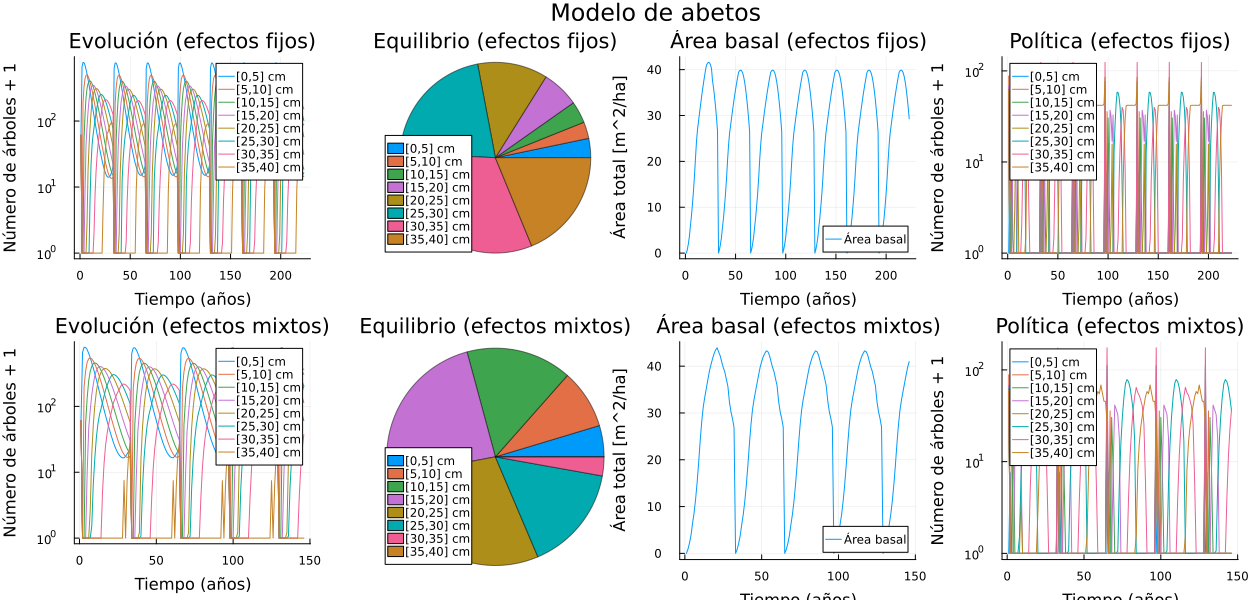

In [38]:
Y_abeto_fixed3, C_abeto_fixed3, BA_abeto_fixed3 = simulate(model_abeto_fixed3)
Y_abeto_mixed3, C_abeto_mixed3, BA_abeto_mixed3 = simulate(model_abeto_mixed3)

print("Masa total inicial = ");println(sum(Y_abeto_fixed3[1,:]))
print("Masa total en equilibrio (efectos fijos) = ");println(sum(Y_abeto_fixed3[end,:]))
print("Masa total en equilibrio (efectos mixtos) = ");println(sum(Y_abeto_mixed3[end,:]))
print("Área basal total máxima (efectos fijos) = ");println(maximum(BA_abeto_fixed3))
print("Área basal total máxima (efectos mixtos) = ");println(maximum(BA_abeto_mixed3))
pf1 = plot(Y_abeto_fixed3 .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm, bottom_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pf2 = pie(legends_pie, Y_abeto_fixed3[end,:], title = "Equilibrio (efectos fijos)", l = 0.5)
pf3 = plot(BA_abeto_fixed3, label="Área basal", title="Área basal (efectos fijos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pf4 = plot(C_abeto_fixed3 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm1 = plot(Y_abeto_mixed3 .+ 1, yaxis=:log10, label = legends, bottom_margin=5mm,
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm2 = pie(legends_pie, Y_abeto_mixed3[end,:], title = "Equilibrio (efectos mixtos)", l = 0.5)
pm3 = plot(BA_abeto_mixed3, label="Área basal", title="Área basal (efectos mixtos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pm4 = plot(C_abeto_mixed3 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos mixtos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
plot(pf1, pf2, pf3, pf4, pm1, pm2, pm3, pm4, layout=(2,4), size=(1250,600), 
plot_title="Modelo de abetos")

### **Abedul**

In [41]:
model_abedul_fixed_aprox = dep_model(diam_otros, surviv_otros_fixed, ingrowth_aprox_abedul)
model_abedul_fixed3 = dep_model(diam_otros, surviv_otros_fixed, BA->ingrowth_conj_BA(BA, coefs_ingrowth_abedul))
SDDP.numerical_stability_report(model_abedul_fixed_aprox)
SDDP.numerical_stability_report(model_abedul_fixed3)
SDDP.train(model_abedul_fixed_aprox; iteration_limit = n_train_iterations)
SDDP.write_cuts_to_file(model_abedul_fixed_aprox, "cuts/abedul_fixed.cuts.json")
SDDP.read_cuts_from_file(model_abedul_fixed3, "cuts/abedul_fixed.cuts.json")

numerical stability report
  matrix range     [4e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [8e+04, 8e+04]
  rhs range        [5e-01, 2e+02]
numerical stability report
  matrix range     [4e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [8e+04, 8e+04]
  rhs range        [5e-01, 2e+02]
-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 8
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [28, 28]
  AffExpr in MOI.EqualTo{Float64}         : [10, 10]
  AffExpr in MOI.LessThan{Float64}        : [200, 200]
  VariableRef in MOI.GreaterThan{Float64} : [19, 19]
  VariableRef in M

In [42]:
model_abedul_mixed_aprox = dep_model(diam_otros, surviv_otros_mixed, ingrowth_aprox_abedul)
model_abedul_mixed3 = dep_model(diam_otros, surviv_otros_mixed, BA->ingrowth_conj_BA(BA, coefs_ingrowth_abedul))
SDDP.numerical_stability_report(model_abedul_mixed_aprox)
SDDP.numerical_stability_report(model_abedul_mixed3)
SDDP.train(model_abedul_mixed_aprox; iteration_limit = n_train_iterations)
SDDP.write_cuts_to_file(model_abedul_mixed_aprox, "cuts/abedul_mixed.cuts.json")
SDDP.read_cuts_from_file(model_abedul_mixed3, "cuts/abedul_mixed.cuts.json")

numerical stability report
  matrix range     [4e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [8e+04, 8e+04]
  rhs range        [5e-01, 2e+02]
numerical stability report
  matrix range     [4e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [8e+04, 8e+04]
  rhs range        [5e-01, 2e+02]
-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 8
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [28, 28]
  AffExpr in MOI.EqualTo{Float64}         : [10, 10]
  AffExpr in MOI.LessThan{Float64}        : [200, 200]
  VariableRef in MOI.GreaterThan{Float64} : [19, 19]
  VariableRef in M

Confidence interval: 2998.86 ± 470.34
Upper bound: 1853.08
Confidence interval: 2838.26 ± 567.99
Upper bound: 3342.93
Masa total inicial = 480.0
Masa total en equilibrio (efectos fijos) = 1843.5207166326306
Masa total en equilibrio (efectos mixtos) = 580.9043301791429
Área basal total máxima (efectos fijos) = 16.369015293373106
Área basal total máxima (efectos mixtos) = 41.242007679967706


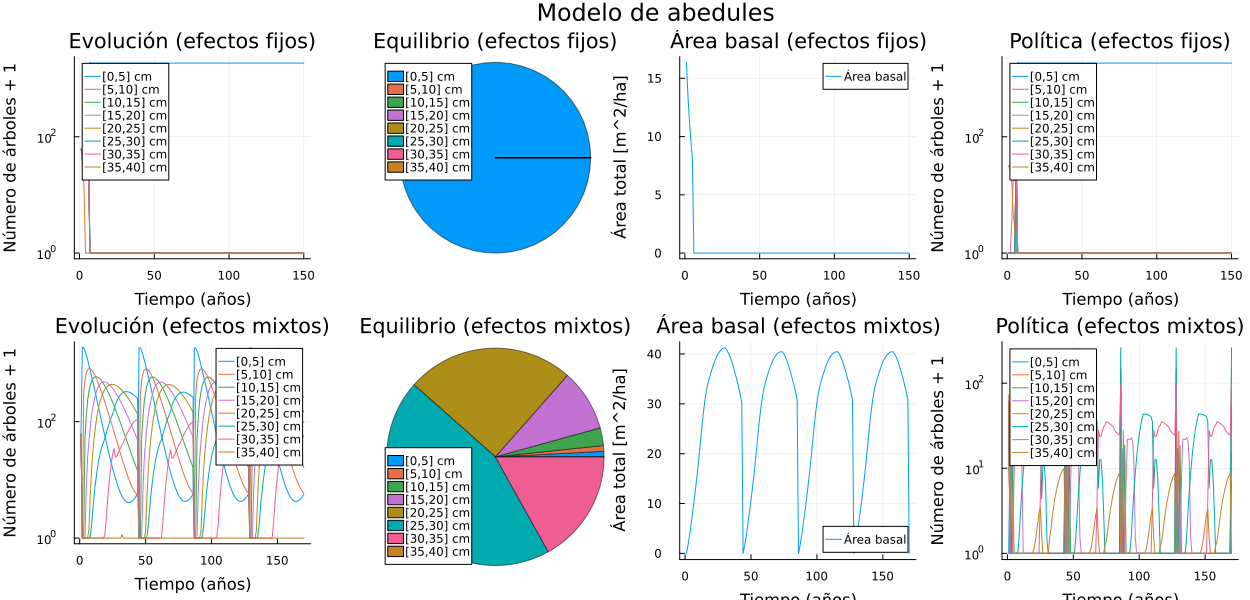

In [43]:
Y_abedul_fixed3, C_abedul_fixed3, BA_abedul_fixed3 = simulate(model_abedul_fixed3)
Y_abedul_mixed3, C_abedul_mixed3, BA_abedul_mixed3 = simulate(model_abedul_mixed3)

print("Masa total inicial = ");println(sum(Y_abedul_fixed3[1,:]))
print("Masa total en equilibrio (efectos fijos) = ");println(sum(Y_abedul_fixed3[end,:]))
print("Masa total en equilibrio (efectos mixtos) = ");println(sum(Y_abedul_mixed3[end,:]))
print("Área basal total máxima (efectos fijos) = ");println(maximum(BA_abedul_fixed3))
print("Área basal total máxima (efectos mixtos) = ");println(maximum(BA_abedul_mixed3))
pf1 = plot(Y_abedul_fixed3 .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm, bottom_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pf2 = pie(legends_pie, Y_abedul_fixed3[end,:], title = "Equilibrio (efectos fijos)", l = 0.5)
pf3 = plot(BA_abedul_fixed3, label="Área basal", title="Área basal (efectos fijos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pf4 = plot(C_abedul_fixed3 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm1 = plot(Y_abedul_mixed3 .+ 1, yaxis=:log10, label = legends, bottom_margin=5mm,
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm2 = pie(legends_pie, Y_abedul_mixed3[end,:], title = "Equilibrio (efectos mixtos)", l = 0.5)
pm3 = plot(BA_abedul_mixed3, label="Área basal", title="Área basal (efectos mixtos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pm4 = plot(C_abedul_mixed3 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos mixtos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
plot(pf1, pf2, pf3, pf4, pm1, pm2, pm3, pm4, layout=(2,4), size=(1250,600), 
plot_title="Modelo de abedules")


### **Otros (broadleaf)**

In [44]:
model_otros_fixed_aprox = dep_model(diam_otros, surviv_otros_fixed, ingrowth_aprox_otros)
model_otros_fixed3 = dep_model(diam_otros, surviv_otros_fixed, BA->ingrowth_conj_BA(BA, coefs_ingrowth_otros))
SDDP.numerical_stability_report(model_otros_fixed_aprox)
SDDP.numerical_stability_report(model_otros_fixed3)
SDDP.train(model_otros_fixed_aprox; iteration_limit = n_train_iterations)
SDDP.write_cuts_to_file(model_otros_fixed_aprox, "cuts/otros_fixed.cuts.json")
SDDP.read_cuts_from_file(model_otros_fixed3, "cuts/otros_fixed.cuts.json")

numerical stability report
  matrix range     [4e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [8e+04, 8e+04]
  rhs range        [5e-01, 2e+02]
numerical stability report
  matrix range     [4e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [8e+04, 8e+04]
  rhs range        [5e-01, 2e+02]
-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 8
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [28, 28]
  AffExpr in MOI.EqualTo{Float64}         : [10, 10]
  AffExpr in MOI.LessThan{Float64}        : [200, 200]
  VariableRef in MOI.GreaterThan{Float64} : [19, 19]
  VariableRef in M

In [45]:
model_otros_mixed_aprox = dep_model(diam_otros, surviv_otros_mixed, ingrowth_aprox_otros)
model_otros_mixed3 = dep_model(diam_otros, surviv_otros_mixed, BA->ingrowth_conj_BA(BA, coefs_ingrowth_otros))
SDDP.numerical_stability_report(model_otros_mixed_aprox)
SDDP.numerical_stability_report(model_otros_mixed3)
SDDP.train(model_otros_mixed_aprox; iteration_limit = n_train_iterations)
SDDP.write_cuts_to_file(model_otros_mixed_aprox, "cuts/otros_mixed.cuts.json")
SDDP.read_cuts_from_file(model_otros_mixed3, "cuts/otros_mixed.cuts.json")

numerical stability report
  matrix range     [4e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [8e+04, 8e+04]
  rhs range        [5e-01, 2e+02]
numerical stability report
  matrix range     [4e-03, 8e+01]
  objective range  [1e+00, 1e+00]
  bounds range     [8e+04, 8e+04]
  rhs range        [5e-01, 2e+02]
-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-25
-------------------------------------------------------------------
problem
  nodes           : 1
  state variables : 8
  scenarios       : Inf
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [28, 28]
  AffExpr in MOI.EqualTo{Float64}         : [10, 10]
  AffExpr in MOI.LessThan{Float64}        : [200, 200]
  VariableRef in MOI.GreaterThan{Float64} : [19, 19]
  VariableRef in M

Confidence interval: 1623.05 ± 279.58
Upper bound: 1751.57
Confidence interval: 3444.42 ± 916.06
Upper bound: 3138.4
Masa total inicial = 480.0
Masa total en equilibrio (efectos fijos) = 507.6444818490698
Masa total en equilibrio (efectos mixtos) = 1037.7709617798992
Área basal total máxima (efectos fijos) = 16.402201532949363
Área basal total máxima (efectos mixtos) = 19.351434074963635


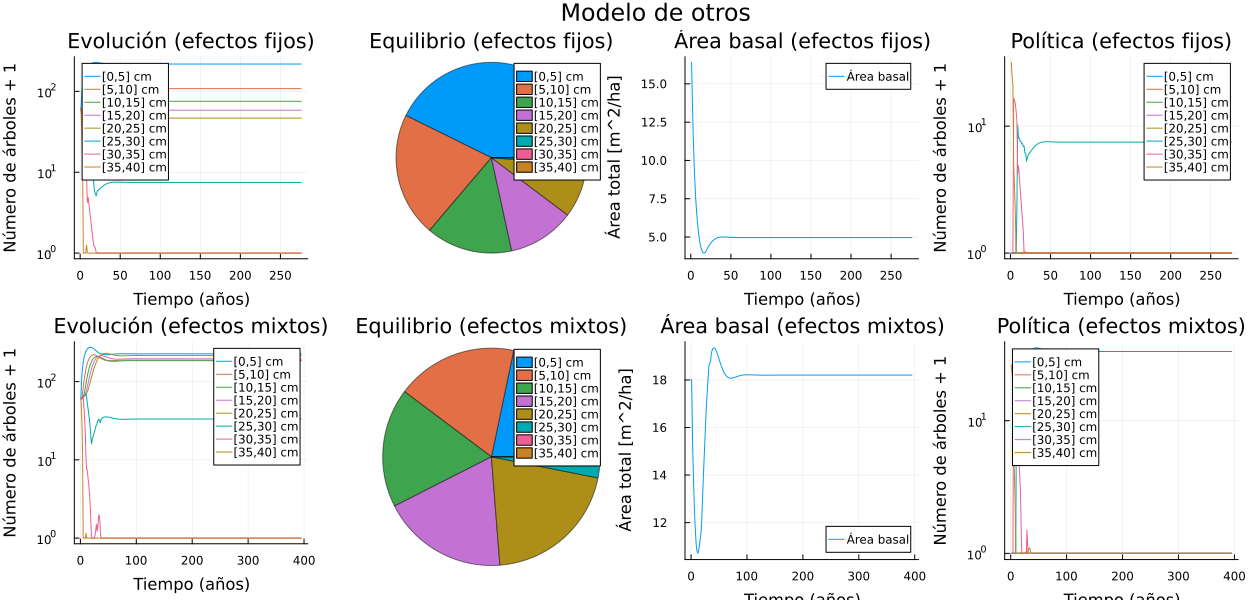

In [46]:
Y_otros_fixed3, C_otros_fixed3, BA_otros_fixed3 = simulate(model_otros_fixed3)
Y_otros_mixed3, C_otros_mixed3, BA_otros_mixed3 = simulate(model_otros_mixed3)

print("Masa total inicial = ");println(sum(Y_otros_fixed3[1,:]))
print("Masa total en equilibrio (efectos fijos) = ");println(sum(Y_otros_fixed3[end,:]))
print("Masa total en equilibrio (efectos mixtos) = ");println(sum(Y_otros_mixed3[end,:]))
print("Área basal total máxima (efectos fijos) = ");println(maximum(BA_otros_fixed3))
print("Área basal total máxima (efectos mixtos) = ");println(maximum(BA_otros_mixed3))
pf1 = plot(Y_otros_fixed3 .+ 1, yaxis=:log10, label = legends, 
    title = "Evolución (efectos fijos)", left_margin=5mm, bottom_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pf2 = pie(legends_pie, Y_otros_fixed3[end,:], title = "Equilibrio (efectos fijos)", l = 0.5)
pf3 = plot(BA_otros_fixed3, label="Área basal", title="Área basal (efectos fijos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pf4 = plot(C_otros_fixed3 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos fijos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm1 = plot(Y_otros_mixed3 .+ 1, yaxis=:log10, label = legends, bottom_margin=5mm,
    title = "Evolución (efectos mixtos)", 
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
pm2 = pie(legends_pie, Y_otros_mixed3[end,:], title = "Equilibrio (efectos mixtos)", l = 0.5)
pm3 = plot(BA_otros_mixed3, label="Área basal", title="Área basal (efectos mixtos)", xlabel="Tiempo (años)", ylabel = "Área total [m^2/ha]")
pm4 = plot(C_otros_mixed3 .+ 1, yaxis=:log10, label = legends, 
    title = "Política (efectos mixtos)", left_margin=5mm,
    xlabel = "Tiempo (años)", ylabel = "Número de árboles + 1")
plot(pf1, pf2, pf3, pf4, pm1, pm2, pm3, pm4, layout=(2,4), size=(1250,600), 
plot_title="Modelo de otros")
